In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score, precision_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA, LatentDirichletAllocation
from sklearn.manifold import TSNE

from tqdm.notebook import tqdm, trange
from typing import NoReturn, Union, List
import tensorflow as tf
from mlxtend.classifier import EnsembleVoteClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP

In [2]:
df = pd.read_csv('C:/Users/Dino_P340/Documents/KaggleExp/CreditCardFraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Dataset
V{1-28}: PCA decompossition outcome
Class label (0: normal, 1: fraudulent)
Time: Number of seconds elapsed between this transaction and the first transaction in the dataset
Amount: transaction amount

In [3]:
# use a dataset sample for development purposes
dev = False

<AxesSubplot:title={'center':'Fraudulent VS Genuine Transactions'}, ylabel='Class'>

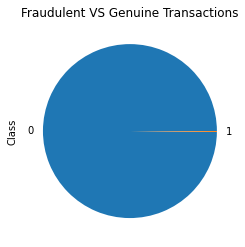

In [4]:
df.groupby(['Class']).Class.count().plot(kind='pie', title='Fraudulent VS Genuine Transactions')

In [5]:
df_s = df.sample(2000)
X = df_s[[_ for _ in df.columns if _ != 'Class']]

pca = PCA(n_components=2)
tsne = TSNE(n_components=2)
ump = UMAP(n_components=2)
ipca = IncrementalPCA(n_components=2)

x_pca = pca.fit_transform(X)
x_tsne = tsne.fit_transform(X)
x_umap = ump.fit_transform(X)

C:\Users\Dino_P340\.conda\envs\Experiments\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dino_P340\.conda\envs\Experiments\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


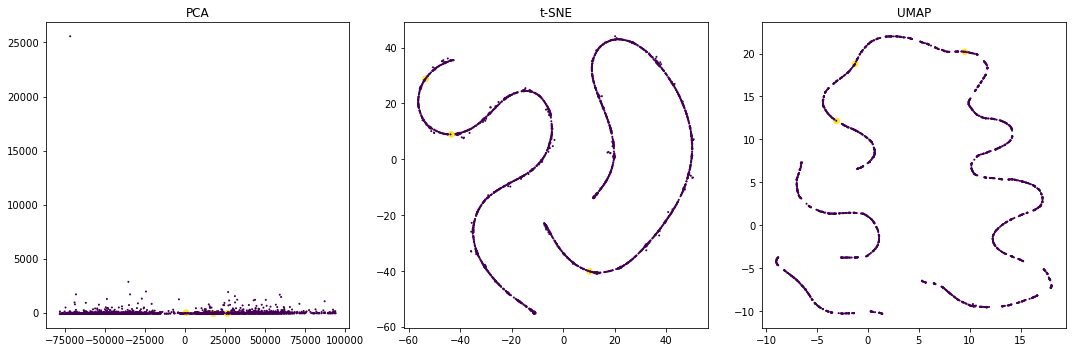

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sizes = pd.Series(df_s['Class']+1).pow(5) # represent fraud with bigger point

axes[0].scatter(x_pca[:, 0], x_pca[:, 1], s=sizes, c=df_s['Class'].values)
axes[1].scatter(x_tsne[:, 0], x_tsne[:, 1], s=sizes, c=df_s['Class'].values)
axes[2].scatter(x_umap[:, 0], x_umap[:, 1], s=sizes, c=df_s['Class'].values)

axes[0].set_title('PCA')
axes[1].set_title('t-SNE')
axes[2].set_title('UMAP')

fig.tight_layout()
plt.show()

Preprocessing
Time and Amount fields should be scaled

During the step of pre-processing, the dataset will be splited in two parts:

~283K samples of genuine transactions (Training set)
All fraudulent samples and equal number of genuine samples (Test set)
Novelty detection is concered as a semi-supervised task due to the fact that only the normal samples are used during the phase of training. During the phase of evaluation, a balanced subset of genuine and fraudulent samples will be used.

In [7]:
# time and amount scaling
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))

df_anom = df[df['Class'] == 1]
df_norm = df[df['Class'] == 0]

if dev:
    df_norm = df_norm.sample(5000, random_state=42)
df_test_norm = df_norm.sample(df_anom.shape[0])
df_test = pd.concat([
    df_anom,
    df_test_norm
])
df_train = df_norm.drop(df_test_norm.index)

feature_cols = [_ for _ in df.columns if _ != 'Class']

In [8]:
X_train = df_train[feature_cols]
y_train = df_train['Class'] # will not be used
X_test = df_test[feature_cols]
y_test = df_test['Class'] # for evaluation
print('''
train: [{:>8} x {:<5}]
 test: [{:>8} x {:<5}]
'''.format(*X_train.shape, *X_test.shape))


train: [  283823 x 30   ]
 test: [     984 x 30   ]



In [9]:
def sensitivity_keras(y_true, y_pred):
    """credits: https://datascience.stackexchange.com/a/40746/28592
    
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = tf.keras.backend.sum(neg_y_true * y_pred)
    tn = tf.keras.backend.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + tf.keras.backend.epsilon())
    return specificity

Training
We are going to define some wrappers, these classes will work as adapters in order to have an abstract implementation.

In [10]:
class Scaled_IsolationForest(IsolationForest):
    """The purpose of this sub-class is to transform prediction values from {-1, 1} to {1,0}
    """
    def predict(self, X):
        pred = super().predict(X)
        scale_func = np.vectorize(lambda x: 1 if x == -1 else 0)
        return scale_func(pred)

class Scaled_OneClass_SVM(OneClassSVM):
    """The purpose of this sub-class is to transform prediction values from {-1, 1} to {1,0}
    """
    def predict(self, X):
        return np.array([y==-1 for y in super().predict(X)])
    
class NoveltyDetection_Sequential(tf.keras.models.Sequential):
    """This custom `tf.keras.models.Sequential` sub-class transforms autoencoder's output into {1,0}.
    Output value is determined based on reproduction (decode) loss. If reproduction loss is more than a threashold then, the input sample is considered as anomaly (outlier).
    Based on few experiments, 1.5 is a dissent threashold (don't as why :P). Future work: determine the threashold using a more sophisticated method.
    """
    def predict(self, x, *args, **kwargs):
        pred = super().predict(x, *args, **kwargs)
        mse = np.mean(np.power(x - pred, 2), axis=1)
        scale_func = np.vectorize(lambda x: 1 if x > 1.5 else 0)
        return scale_func(mse)

In [11]:
# define early stop in order to prevent overfitting and useless training
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='mse',
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True,
)

# it's a common practice to store the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoenc.hdf5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=0
)

def get_autoencoder() -> tf.keras.models.Sequential:
    """Build an autoencoder
    """
    model = NoveltyDetection_Sequential([
        tf.keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1], )),
        # add some noise to prevent overfitting
        tf.keras.layers.GaussianNoise(0.05),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(X_train.shape[1], activation='relu')
    ])
    model.compile(optimizer='adam', 
                        loss='mse',
                        metrics=['acc', sensitivity_keras])
    return model

In [12]:
clfs = {
    'isolation_forest': {
        'label': 'Isolation Forest',
        'clb': Scaled_IsolationForest,
        'params': {
            'contamination': 'auto',
            'n_estimators': 300
        },
        'predictions': None,
        'model': None
    },
    'ocsvm': {
        'label': 'OneClass SVM',
        'clb': Scaled_OneClass_SVM,
        'params': {
            'kernel': 'rbf',
            'gamma': 0.3,
            'nu': 0.01,
        },
        'prediction': None,
        'model': None
    },
    'auto-encoder': {
        'label': 'Autoncoder',
        'clb': get_autoencoder,
        'params': {},
        'fit_params': {
            'x': X_train, 'y': X_train,
            'validation_split': 0.2,
            'callbacks': [early_stop, checkpoint],
            'epochs': 64,
            'batch_size': 256,
            'verbose': 0
        },
        'predictions': None,
        'model': None
    }
}

In [ ]:
%%time

t = trange(len(clfs))
for name in clfs:
    t.set_description(clfs[name]['label'])
    clfs[name]['model'] = clfs[name]['clb'](**clfs[name]['params'])
    if 'fit_params' in clfs[name]:
        clfs[name]['model'].fit(**clfs[name].get('fit_params', {}))
    else:
        clfs[name]['model'].fit(X_train)
    clfs[name]['predictions'] = clfs[name]['model'].predict(X_test)
    t.update()
t.close()

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def print_eval_metrics(y_true, y_pred, name='', header=True):
    """Function for printing purposes
    """
    if header:
        print('{:>20}\t{:>10}\t{:>10}\t{:>8}\t{:>5}'.format('Algorith', 'Accuracy', 'Recall', 'Precision', 'f1'))
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('{:>20}\t{:>1.8f}\t{:>1.8f}\t{:>1.6f}\t{:>1.3f}'.format(
        name, acc, recall, prec, f1
    ))

Enseble

In [ ]:
y_preds = np.column_stack([clfs[_]['predictions'] for _ in clfs])
enseble_preds = []

Hard Voting
This is one of the simplest way to combine multiple models in order to generalize better and achive better performance.

In [ ]:
hard_vot = EnsembleVoteClassifier([clfs[_]['model'] for _ in clfs], fit_base_estimators=False)
hard_vot.fit(X_test, y_test)
enseble_preds.append((hard_vot.predict(X_test), 'Hard Voting'))

Weighted Hard Voting
Using weighted hard voting you can take advantage of most high-performed models

In [ ]:
wei_hard_vot = EnsembleVoteClassifier([clfs[_]['model'] for _ in clfs], weights=[
        0.4,
        0.1,
        0.8
    ], fit_base_estimators=False)
wei_hard_vot.fit(X_test, y_test)
enseble_preds.append((wei_hard_vot.predict(X_test), 'Weighted Hard Voting'))

Blending
We are going to use the the predicted values as input to another model

In [ ]:
rf = RandomForestClassifier()

x_tr_ens, x_ts_ens, y_tr_ens, y_ts_ens = train_test_split(y_preds, y_test, test_size=.5)
rf.fit(x_tr_ens, y_tr_ens)

Evaluation
It's crusial to detect fraudulent transactions, therefor a significat evaluation metric could the simplicity. For every trained method and ensebling method the following evaluation metrics will be calculated:

Accuracy
Recall
Precision
f1 Score

In [ ]:
print_header = True
for k, v in clfs.items():
    print_eval_metrics(y_test, v['predictions'], v['label'], print_header)
    print_header = False

print('\n')

for prds, l in enseble_preds:
    print_eval_metrics(y_test, prds, l, print_header)
    print_header = False

print('\n')
    
print_eval_metrics(
    y_ts_ens,
    rf.predict(x_ts_ens),
    'Bleding using RF', False
)

Future Work
Find the auto-encoding loss threashold using a more sophisticated way
Test more models and different configurations

https://www.kaggle.com/sp1thas/semi-supervised-fraud-detection/notebook